In [37]:
# Open VSCode and create a new project folder for your machine learning project.
# Open the terminal in VSCode by going to Terminal > New Terminal.
# Create a new environment using conda or pip. For example, to create a new environment with conda:
#     conda create --name myenv
#     conda activate myenv
# Install the necessary packages for your machine learning project. For example, to install scikit-learn:
#     conda install pandas numpy scikit-learn flask
#     pip install -r requirements.txt             use this if you had initially loaded some packages to the file
# Export the dependencies of your project by running the command:
#     pip freeze > requirements.txt

<br>Table of Content:
* [Import Libraries](#1)
* [Load Data](#2)
* [Exploratory Data Analysis (EDA)](#3)
* [Building the Model](#4)
* [Saving the Model](#5) 
* [Deploy the Model](#6) 

<a id="1"></a> <br>
## Import Libraries

In [38]:
# Data Analysis      
import pandas as pd          # data analysis library for handling structured data  
# import modin.pandas as pd       # Speed up your Pandas workflows 
from pandas import DataFrame            
import numpy as np           # mathematical library for working with numerical data
import ydata_profiling  #for auto EDA
import datetime 
import dtale        #for auto Exploratory Data Analysis

# Visualization
import matplotlib.pyplot as plt     # data visualization library for creating graphs and charts
%matplotlib inline
import seaborn as sns        # data visualization library based on matplotlib for creating more attractive visualizations
import plotly.io as pio
import plotly.express as px   # interactive data visualization library
import plotly.graph_objects as go   # library for creating interactive graphs and charts
import kaleido 


# Machine Learning/Time Series 
import evalml 
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder # Preprocessing feature scaling/categorical encoding

#ML - Tune your model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Ignore warnings
import warnings
warnings.filterwarnings("ignore") 

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<a id="2"></a> <br>
## Load Data

In [39]:
train_df = pd.read_csv("Dataset/raw/train_data.csv", infer_datetime_format=True, parse_dates=["Date"])
test_df = pd.read_csv("Dataset/raw/test_data.csv", infer_datetime_format=True, parse_dates=["Date"])

In [40]:
train_df.set_index("Date", inplace=True)
test_df.set_index("Date", inplace=True)


train_df.head()

,Petrol (USD)
Date,
2003-06-09,74.59
2003-06-16,74.47
2003-06-23,74.42
2003-06-30,74.35
2003-07-07,74.28


In [41]:
test_df

,Prediction
Date,
2019-01-01,NaN
2019-01-02,NaN
2019-01-03,NaN
2019-01-04,NaN
2019-01-05,NaN
...,...
2019-01-12,NaN
2020-01-01,NaN
2020-01-02,NaN


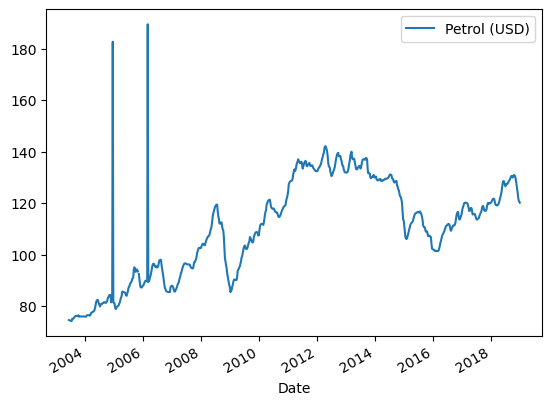

In [42]:
train_df.plot()
plt.savefig('Images/time_series_plot.png') 

>> Data DESCR

In [43]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Petrol (USD),811.0,110.330481,19.241182,74.21,94.525,112.42,128.56,189.51


In [44]:
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 813 entries, 2003-06-09 to 2018-12-31
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Petrol (USD)  811 non-null    float64
dtypes: float64(1)
memory usage: 12.7 KB


<a id="3"></a> <br>
## Exploratory Data Analysis (EDA)

>> Data Profiling

In [45]:
def do_data_profiling(df, filename):
    '''
    Function to do basic data profiling
    Required Input - 
        - df = Pandas DataFrame
        - filename = Path for output file with a .html extension
    Expected Output -
        - HTML file with data profiling summary
    '''
    profile = ydata_profiling.ProfileReport(df) #replacing pandas_profiling with ydata_profiling
    profile.to_file(output_file = filename)
    print("Data profiling done")

do_data_profiling(train_df, 'data_profiling.html') 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Data profiling done


In [46]:
#findings from data profiling:

# Missing cells	2
# Duplicate rows	55 (6.8%)   #this doesn't really matter in this context


>> Auto EDA using dtale

In [47]:
dtale.show(train_df) 

In [48]:
test_df.head()

,Prediction
Date,
2019-01-01,NaN
2019-01-02,NaN
2019-01-03,NaN
2019-01-04,NaN
2019-01-05,NaN


>> Fix NaN

In [49]:
# count the number of missing values per column
# df_train[df_train['Petrol (USD)'].isnull().any()]

train_df[train_df['Petrol (USD)'].isnull()]


,Petrol (USD)
Date,
2005-10-31,NaN
2006-11-20,NaN


In [50]:
#fix missing values
from sklearn.impute import SimpleImputer

def treat_missing_numeric(df,columns,how = 'mean', value = None):
    '''
    Function to treat missing values in numeric columns
    Required Input - 
        - df = Pandas DataFrame
        - columns = List input of all the columns need to be imputed
        - how = valid values are 'mean', 'mode', 'median','ffill', numeric value
    Expected Output -
        - Pandas dataframe with imputed missing value in mentioned columns
    '''
    if how == 'ffill':
        for i in columns:
            print("Filling missing values with forward fill for columns - {0}".format(i))
            df[i] = df[i].fillna(method ='ffill')
    
    elif how == 'digit':
        for i in columns:
            print("Filling missing values with {0} for columns - {1}".format(how, i))
            df[i] = df[i].fillna(str(value)) 
      
    else:
        print("Missing value fill cannot be completed")
    return df

train_df = treat_missing_numeric(train_df, ["Petrol (USD)"], how="ffill")
# df_test = treat_missing_numeric(df_test, ["Petrol (USD)"], how="ffill")

Filling missing values with forward fill for columns - Petrol (USD)


In [51]:
#verifying the NaN ffill

train_df.loc['2005-10-31', :], train_df.loc['2006-11-20']

(Petrol (USD)    93.47
 Name: 2005-10-31 00:00:00, dtype: float64,
 Petrol (USD)    85.49
 Name: 2006-11-20 00:00:00, dtype: float64)

>> Scale

In [52]:
train_df = train_df.reset_index()

train_df.shape, train_df.head()

((813, 2),
         Date  Petrol (USD)
 0 2003-06-09         74.59
 1 2003-06-16         74.47
 2 2003-06-23         74.42
 3 2003-06-30         74.35
 4 2003-07-07         74.28)

In [53]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

train_df['Petrol (USD)'] = pd.DataFrame(scaler.fit_transform(train_df.iloc[:, 1:])) 

In [54]:
train_df.head() 

,Date,Petrol (USD)
0,2003-06-09,0.003296
1,2003-06-16,0.002255
2,2003-06-23,0.001821
3,2003-06-30,0.001214
4,2003-07-07,0.000607


In [55]:
# Split data into train and test
cutoff = int(len(train_df) * 0.8) # 80% for training 
train = train_df.iloc[:cutoff] 
test_df = train_df.iloc[cutoff:] 
train_df = train 

#exorting the preprocessed data 
train_df.to_csv(r'Dataset/processed/train_df.csv', index=False)
test_df.to_csv(r'Dataset/processed/test_df.csv', index=False)


<a id="4"></a> <br>
## Building the Model

>> Time Step

In [56]:
train_df.shape, test_df.shape 

((650, 2), (163, 2))

In [57]:

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), 1]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 1])
    return np.array(dataX), np.array(dataY)

# Split the dataset into input (X) and output (y) arrays
X_train, y_train = create_dataset(train_df.values, time_step=10)
X_test, y_test = create_dataset(test_df.values, time_step=10)


In [58]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')  

In [59]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape  

((640, 10), (640,), (153, 10), (153,))

>> LSTM for Time Series Prediction

In [60]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import LSTM

In [61]:

# build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [62]:
# train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# evaluate the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test) 

Epoch 1/100
10/10 [==============================] - 11s 264ms/step - loss: 0.0465 - val_loss: 0.0150
Epoch 2/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0138 - val_loss: 0.0104
Epoch 3/100
10/10 [==============================] - 0s 27ms/step - loss: 0.0098 - val_loss: 0.0014
Epoch 4/100
10/10 [==============================] - 0s 36ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 5/100
10/10 [==============================] - 0s 43ms/step - loss: 0.0042 - val_loss: 7.0471e-04
Epoch 6/100
10/10 [==============================] - 0s 27ms/step - loss: 0.0039 - val_loss: 8.7860e-04
Epoch 7/100
10/10 [==============================] - 0s 27ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 8/100
10/10 [==============================] - 0s 27ms/step - loss: 0.0037 - val_loss: 6.0640e-04
Epoch 9/100
10/10 [==============================] - 0s 27ms/step - loss: 0.0037 - val_loss: 8.1228e-04
Epoch 10/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0037 

In [63]:
train_predict.shape

(640, 1)

In [64]:
train_predict.shape

(640, 1)

In [65]:
# invert the scaling
train_predict = scaler.inverse_transform(train_predict)
y_train = y_train.reshape(-1, 1) #check why this is 
y_train = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test = y_test.reshape(-1, 1)  #check why this is 
y_test = scaler.inverse_transform(y_test)



In [66]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
import math 
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print('Train RMSE: %.2f' % (train_rmse))
print('Test RMSE: %.2f' % (test_rmse))

Train RMSE: 6.41
Test RMSE: 2.08



<a id="5"></a> <br>
## Saving the Model

In [67]:
#save fitted scaler
import joblib

# save the fitted scaler to disk
joblib.dump(scaler, 'models/scaler.joblib')

['models/scaler.joblib']

In [68]:
#saving the model

from keras.models import load_model

def save_model(model, filename):
    """
    Save a trained scikit-learn model to disk using joblib.
    """
    try: 
        model.save(filename)
        print(f"Model saved to {filename}")
    except Exception as e:
        print(f"Error saving model to {filename}: {e}")

save_model(model, 'models/crude_price.h5')


Model saved to models/crude_price.h5


In [69]:
# target_date = pd.to_datetime("2022-06-10")
# target_index = len(train_df)  # start by assuming the target date is after the last date in the training data
# for i in range(len(train_df)):
#     if train_df.loc[i, "Date"] >= target_date:
#         target_index = i
#         break

# time_steps = 10 
# start_index = target_index - time_steps
# if start_index < 0:
#     raise ValueError("Not enough data to make prediction")
# sequence = train_df.iloc[start_index:target_index]["Petrol (USD)"].values

# # pad the sequence with zeros if there are less than `time_steps` data points available
# if len(sequence) < time_steps:
#     sequence = np.pad(sequence, (time_steps - len(sequence), 0), mode="constant", constant_values=0)

# sequence = sequence.reshape(1, time_steps, 1)

# predicted_price = model.predict(sequence)[0][0]
# predicted_price = scaler.inverse_transform(predicted_price.reshape(1, -1))#[0][0] 

# print(f"The Petrol Price for the year {target_date} is: USD{predicted_price} ")

<a id="6"></a> <br>
## Deploy the Model

In [70]:

def predict_petrol_price(train_df, target_date, scaler, model:str): 
    # target_date = pd.to_datetime(target_date)
    try:
        target_date = pd.to_datetime(target_date)
    except ValueError:
        return "Invalid date format. Please enter date in YYYY-MM-DD format."
    
    # if target_date < train_df["Date"].min():
    #     raise ValueError("Target date is earlier than first date in training data")
    
    if target_date < train_df["Date"].min():
        return "Target date is earlier than first date in training data"
    
    target_index = len(train_df)  # start by assuming the target date is after the last date in the training data
    
    for i in range(len(train_df)):
        if train_df.loc[i, "Date"] >= target_date:
            target_index = i
            break

    time_steps = 10
    start_index = target_index - time_steps
    if start_index < 0:
        raise ValueError("Not enough data to make prediction")
    sequence = train_df.iloc[start_index:target_index]["Petrol (USD)"].values

    # pad the sequence with zeros if there are less than `time_steps` data points available
    if len(sequence) < time_steps:
        sequence = np.pad(sequence, (time_steps - len(sequence), 0), mode="constant", constant_values=0)

    sequence = sequence.reshape(1, time_steps, 1)
    model = load_model(model)  
    predicted_price = model.predict(sequence)[0][0]
    if scaler == None:
        scaler = MinMaxScaler(feature_range=(0, 1))  
    predicted_price = scaler.inverse_transform(predicted_price.reshape(1, -1))
    print(f"The Petrol Price for the year {target_date} is: USD{predicted_price} ")
    # return predicted_price #[0][0] 


target_date = input("Enter date in YYYY-MM-DD format: ")

predict_petrol_price(train_df,  target_date, scaler, model = 'models/crude_price.h5')


1/1 [==============================] - 6s 6s/step
The Petrol Price for the year 2020-12-10 00:00:00 is: USD[[108.71155]] 


In [71]:
# def predict_petrol_price(): 
#     try:
#         target_date = datetime.strptime(request.form['target_date'], '%Y-%m-%d')        
#     except ValueError:
#         return render_template('prediction.html', prediction_error='Invalid date format. Please enter date in YYYY-MM-DD format.')
    
#     if target_date < train_df["Date"].min():
#         return render_template('prediction.html', prediction_error='Target date is earlier than first date in training data')
    
#     for i in range(len(train_df)):
#         # if train_df.loc[i, "Date"] >= target_date:
#         if train_df.loc[i, "Date"] >= pd.Timestamp(target_date):
#             target_index = i
#             break

#     time_steps = 10
#     start_index = target_index - time_steps
#     if start_index < 0:
#         raise ValueError("Not enough data to make prediction")
#     sequence = train_df.iloc[start_index:target_index]["Petrol (USD)"].values

#     # pad the sequence with zeros if there are less than `time_steps` data points available
#     if len(sequence) < time_steps:
#         sequence = np.pad(sequence, (time_steps - len(sequence), 0), mode="constant", constant_values=0)

#     sequence = sequence.reshape(1, time_steps, 1)
#     # model = load_model(model)  
#     predicted_price = model.predict(sequence)[0][0]
#     if scaler == None:
#         scaler = MinMaxScaler(feature_range=(0, 1))  
#     predicted_price = scaler.inverse_transform(predicted_price.reshape(1, -1))
#     prediction_str = "${:,.2f}".format(predicted_price[0][0])   # format prediction as currency string
    
#      # render prediction template with predicted price
#     return render_template('prediction.html', predicted_price = prediction_str, target_date = target_date)

In [72]:
# def predict_petrol_price(): 
#     # target_date = pd.to_datetime(target_date) 
#     try:
#         # target_date = pd.to_datetime(request.form['target_date']) 
#         target_date = datetime.strptime(request.form['target_date'], '%Y-%m-%d')        
#     except ValueError:
#         return render_template('prediction.html', prediction_error='Invalid date format. Please enter date in YYYY-MM-DD format.')
#     target_date = pd.Timestamp(target_date)  # convert target_date to pd.Timestamp object
#     # try:
#     #     target_date = pd.to_datetime(target_date)
#     # except ValueError:
#     #     return "Invalid date format. Please enter date in YYYY-MM-DD format."    
#     # if target_date < train_df["Date"].min():
#     #     return "Target date is earlier than first date in training data"
    
#     if target_date < train_df["Date"].min():
#         return render_template('prediction.html', prediction_error='Target date is earlier than first date in training data')
#     # elif not isinstance(target_date, pd.Timestamp):
#     #     return render_template('prediction.html', prediction_error='Invalid date format. Please enter date in YYYY-MM-DD format.')
#     # else:
#     #     target_index = len(train_df)  # start by assuming the target date is after the last date in the training data

#         # Rest of the code to predict petrol price

#     target_index = len(train_df)  # start by assuming the target date is after the last date in the training data
    
#     for i in range(len(train_df)):
#         # if train_df.loc[i, "Date"] >= target_date:
#         if train_df.loc[i, "Date"] >= pd.Timestamp(target_date):
#             target_index = i
#             break

#     time_steps = 10
#     start_index = target_index - time_steps
#     if start_index < 0:
#         raise ValueError("Not enough data to make prediction")
#     sequence = train_df.iloc[start_index:target_index]["Petrol (USD)"].values

#     # pad the sequence with zeros if there are less than `time_steps` data points available
#     if len(sequence) < time_steps:
#         sequence = np.pad(sequence, (time_steps - len(sequence), 0), mode="constant", constant_values=0)

#     sequence = sequence.reshape(1, time_steps, 1)
#     # model = load_model(model)  
#     predicted_price = model.predict(sequence)[0][0]
#     if scaler == None:
#         scaler = MinMaxScaler(feature_range=(0, 1))  
#     predicted_price = scaler.inverse_transform(predicted_price.reshape(1, -1))
#     prediction_str = "${:,.2f}".format(predicted_price[0][0])   # format prediction as currency string
    
#      # render prediction template with predicted price
#     return render_template('prediction.html', predicted_price = prediction_str, target_date = target_date)

2023-05-12 08:06:26,254 - INFO     - Executing shutdown due to inactivity...
2023-05-12 08:06:30,621 - INFO     - Executing shutdown...
2023-05-12 08:06:30,634 - ERROR    - Exception on /shutdown [GET]
Traceback (most recent call last):
  File "c:\Users\Cornel\anaconda3\envs\paul_flask\lib\site-packages\flask\app.py", line 2528, in wsgi_app
    response = self.full_dispatch_request()
  File "c:\Users\Cornel\anaconda3\envs\paul_flask\lib\site-packages\flask\app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "c:\Users\Cornel\anaconda3\envs\paul_flask\lib\site-packages\flask\app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "c:\Users\Cornel\anaconda3\envs\paul_flask\lib\site-packages\flask\app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "c:\Users\Cornel\anaconda3\envs\paul_flask\lib\site-packages\dtale\app.py", line 433, in shutdown
    shu